In [2]:
import os
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import torch.nn as nn
from scipy.stats import norm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
sns.set()
sns.set_style("whitegrid")
sns.set_context('notebook', font_scale=1.5, rc={"lines.linewidth": 1.5})

Connect with Drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
global root_path 
root_path = '/content/drive/My Drive/Pesquisa/PPGIA/gw_ultimate-main/phase2/'

In [5]:
class NN2HiddenLayer(nn.Module):

    def __init__(self, act_function, hidden_layer_units, input_size=300):
        super(NN2HiddenLayer, self).__init__()

        self.input_size = input_size
        self.output_size = 2

        self.act_function = act_function
        self.hidden_units = hidden_layer_units

        self.input = nn.Linear(self.input_size, hidden_layer_units)
        self.hl1 = act_function
        self.linear_hl2 = nn.Linear(hidden_layer_units, hidden_layer_units)
        self.hl2 = act_function
        self.output = nn.Linear(hidden_layer_units, self.output_size)

    def forward(self, x):

        x = self.input(x)
        x = self.hl1(x)
        x = self.linear_hl2(x)
        x = self.hl2(x)
        return self.output(x)


class Sin(nn.Module):
    """Class to implement the sin function"""

    def __init__(self):
        """Initializer method.
        """
        super(Sin,self).__init__()

    def forward(self, input_):
        return torch.sin(input_)

        
def min_max_local(X):
    X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
    return X_std

def min_max_local_neg(X):
    X_std = (((X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))) - 0.5) * 2.0
    return X_std


def load_data():
    df = pd.read_parquet(root_path + 'data/pycbc/pycbc_database_20_40_all.parquet')

    group_df = df[['mass1', 'mass2', 'value']].groupby(['mass1', 'mass2'])['value'].apply(np.array)
    values = np.array([i[-409:] for i in group_df.values])

    features = min_max_local(values)
    label = group_df.index

    x_train, x_test_validation, y_train, y_test_validation = train_test_split(features, label, test_size=0.3,
                                                                              random_state=2)
    x_test, x_validation, y_test, y_validation = train_test_split(x_test_validation, y_test_validation, test_size=0.5,
                                                                  random_state=2)

    x_train_tensor = torch.tensor(x_train, dtype=torch.float)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float)
    x_validation_tensor = torch.tensor(x_validation, dtype=torch.float)
    y_validation_tensor = torch.tensor(y_validation, dtype=torch.float)
    x_test_tensor = torch.tensor(x_test, dtype=torch.float)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float)

    dataset_train = TensorDataset(x_train_tensor, y_train_tensor)
    dataset_validation = TensorDataset(x_validation_tensor, y_validation_tensor)

    train_loader = DataLoader(dataset=dataset_train, batch_size=x_train.shape[0])
    val_loader = DataLoader(dataset=dataset_validation, batch_size=x_validation.shape[0])
    test_tuple = (x_test_tensor, y_test_tensor)
    return train_loader, val_loader, test_tuple

def load_real_data():
    ligo_filtered_df = pd.read_parquet(root_path + 'data/ligo_data_filtered.parquet')
    ligo_filtered_df['ts'] = ligo_filtered_df['ts'].apply(lambda x: min_max_local(x))
    ligo_filtered_df['ts'] = ligo_filtered_df['ts'].apply(lambda x: np.float64(x))

    real_waves = np.array([*ligo_filtered_df['ts'].values])
    x_real_test = torch.from_numpy(real_waves)

    return x_real_test, ligo_filtered_df['masses'].values, ligo_filtered_df.wave.values

In [13]:
def test_data_result_exp_b(test_tuple, model):

    prediction = model(test_tuple[0])
    diff = test_tuple[1] - prediction

    fig, ax = plt.subplots(1, 2, constrained_layout=True)
    fig.set_figheight(4.5)
    fig.set_figwidth(12)

    sns.distplot(diff.detach().numpy()[:, 0], 20, fit=norm, kde=False, color=sns.color_palette("bright")[0],
                 ax=ax[0])
    # ax[0].set(xlim=(-4, 4), ylim=(0, 0.8))
    ax[0].set_title('M1',  fontsize=16)
    ax[0].set(xlabel='Error', ylabel='Density')

    sns.distplot(diff.detach().numpy()[:, 1], 20, fit=norm, kde=False, color=sns.color_palette("bright")[3],
                 ax=ax[1])
    # ax[1].set(xlim=(-4, 4), ylim=(0, 0.8))
    ax[1].set_title('M2',  fontsize=16)
    ax[1].set(xlabel='Error', ylabel='Density')

    plt.savefig(root_path + 'results/early_stop/round02_test_data_solution.png')
    plt.show()
    return diff

In [7]:
def real_data_result(model):

    x_real, y_real, waves = load_real_data()
    x_real = torch.tensor(x_real, dtype=torch.float)

    prediction = model(x_real)
    y = np.vstack(y_real)
    x = np.ones(y.shape)
    x[:, 0] = y[:, 1]
    x[:, 1] = y[:, 0]
    x, out, waves = np.delete(x, [1, 2, 4, 5, 8], axis=0), np.delete(prediction.detach().numpy(), [1, 2, 4, 5, 8], axis=0), \
                    np.delete(waves, [1, 2, 4, 5, 8])
    diff = x - out
    for i in range(0, len(diff)):
        print(waves[i], '&&', x[i][0], '&', round(out[i][0], 1), '&',
              round(x[i][0] - round(out[i][0], 1), 1), '&&',
              x[i][1], '&', round(out[i][1], 1), '&',
              round(x[i][1] - round(out[i][1], 1), 1), '\\\\')
    fig, ax = plt.subplots(1, 2, constrained_layout=True)
    fig.set_figheight(4.5)
    fig.set_figwidth(12)

    sns.distplot(diff[:, 0], 8, fit=norm, kde=False, color=sns.color_palette("bright")[0],
                 ax=ax[0])
    # ax[0].set(xlim=(-30, 30))
    # ax[0].set(ylim=(0, 0.08))
    ax[0].set_title('M1', fontsize=16)
    ax[0].set(xlabel='Error', ylabel='Density')

    sns.distplot(diff[:, 1], 8, fit=norm, kde=False, color=sns.color_palette("bright")[3],
                 ax=ax[1])
    # ax[1].set(xlim=(-30, 30))
    # ax[1].set(ylim=(0, 0.08))
    ax[1].set_title('M2', fontsize=16)
    ax[1].set(xlabel='Error', ylabel='Density')

    #fig.suptitle('Best Solution with Real Data Results', fontsize=14)
    plt.savefig(root_path + 'results/early_stop/round02_real_data_solution.png')
    plt.show()
    return diff

In [8]:
_, _, test_tuple = load_data()

model = NN2HiddenLayer(Sin(), 200, input_size=409)
checkpoint = torch.load(root_path + 'early_stop/T/exp_T_stats.parquetnn2hlu200afSinlr1e-035735.tar')
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

NN2HiddenLayer(
  (act_function): Sin()
  (input): Linear(in_features=409, out_features=200, bias=True)
  (hl1): Sin()
  (linear_hl2): Linear(in_features=200, out_features=200, bias=True)
  (hl2): Sin()
  (output): Linear(in_features=200, out_features=2, bias=True)
)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


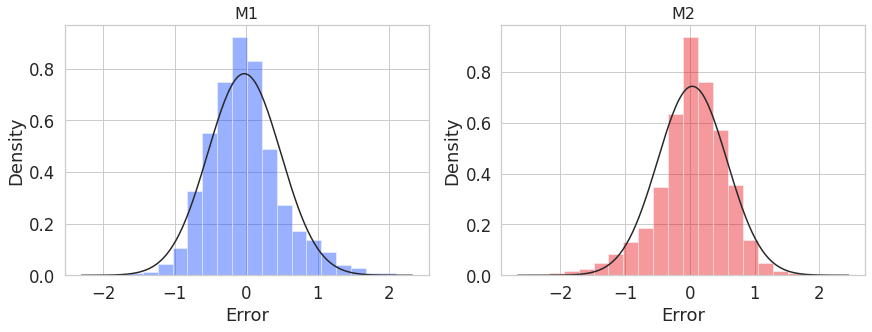

tensor([-0.0257,  0.0390], grad_fn=<MeanBackward1>) tensor(0.0066, grad_fn=<MeanBackward0>)
tensor([0.2613, 0.2880], grad_fn=<VarBackward0>) tensor(0.2757, grad_fn=<VarBackward0>)
tensor([0.5111, 0.5367], grad_fn=<StdBackward0>) tensor(0.5250, grad_fn=<StdBackward0>)
0.27569598
torch.return_types.min(
values=tensor([-2.0717, -2.4107], grad_fn=<MinBackward0>),
indices=tensor([6646, 8835])) tensor(-2.4107, grad_fn=<MinBackward1>)
torch.return_types.max(
values=tensor([2.0935, 2.2083], grad_fn=<MaxBackward0>),
indices=tensor([ 8835, 11889])) tensor(2.2083, grad_fn=<MaxBackward1>)


In [18]:
diff = test_data_result_exp_b(test_tuple, model)
print(diff.mean(axis=0), diff.mean())
print(diff.var(axis=0), diff.var())
print(diff.std(axis=0), diff.std())
print(np.square(diff.detach().numpy()).mean())
print(diff.min(axis=0), diff.min())
print(diff.max(axis=0), diff.max())

In [23]:
diff.max(axis=0)

torch.return_types.max(
values=tensor([2.0935, 2.2083], grad_fn=<MaxBackward0>),
indices=tensor([ 8835, 11889]))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning

GW150914 && 30.6 & 12.5 & 18.1 && 35.6 & 10.9 & 24.7 \\
GW170104 && 20.0 & 11.8 & 8.2 && 30.8 & 13.6 & 17.2 \\
GW170809 && 23.8 & 25.6 & -1.8 && 35.0 & 29.2 & 5.8 \\
GW170814 && 25.2 & 18.3 & 6.9 && 30.6 & 22.9 & 7.7 \\
GW170818 && 26.7 & 22.7 & 4.0 && 35.4 & 28.6 & 6.8 \\
GW170823 && 29.0 & -0.5 & 29.5 && 39.5 & -2.7 & 42.2 \\


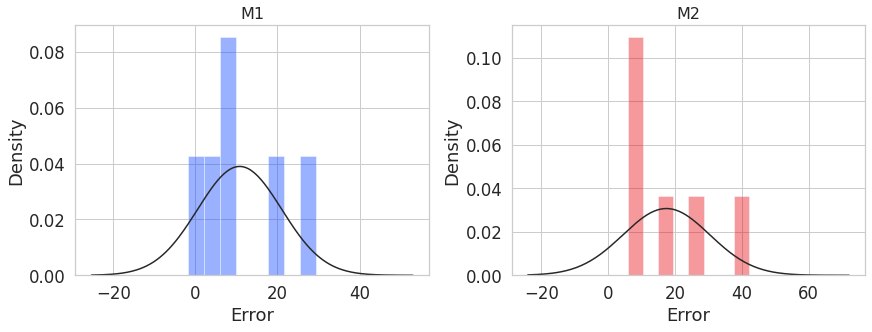

array([[18.13297329, 24.72112999],
       [ 8.16614056, 17.17410545],
       [-1.76704712,  5.7678051 ],
       [ 6.88667984,  7.65042267],
       [ 3.9556572 ,  6.8061718 ],
       [29.46465337, 42.23963213]])

In [10]:
real_data_result(model)

In [11]:
result = np.array([[18.13297329, 24.72112999],
       [ 8.16614056, 17.17410545],
       [-1.76704712,  5.7678051 ],
       [ 6.88667984,  7.65042267],
       [ 3.9556572 ,  6.8061718 ],
       [29.46465337, 42.23963213]])

In [24]:
print(result.mean(axis=0), result.mean())
print(result.var(axis=0), result.var())
print(result.std(axis=0), result.std())
print(np.square(result).mean())
print(result.min(axis=0), result.min())
print(result.max(axis=0), result.max())

[10.80650952 17.39321119] 14.099860356666667
[104.86142006 168.87473879] 147.71423913607757
[10.24018652 12.99518137] 12.153774686741464
346.52030121357785
[-1.76704712  5.7678051 ] -1.76704712
[29.46465337 42.23963213] 42.23963213
